In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
danielfesalbon_young_adults_affective_data_ecg_and_gsr_signals_path = kagglehub.dataset_download('danielfesalbon/young-adults-affective-data-ecg-and-gsr-signals')

print('Data source import complete.')


100%|██████████| 6.17M/6.17M [00:01<00:00, 6.23MB/s]

Extracting files...


Data source import complete.


In [2]:
!pip install wget
!pip install PyGithub
!pip install openpyxl
!pip install neurokit2
!pip install --upgrade scikit-learn==1.4.2 scikeras==0.12.0 tensorflow==2.15
#!pip install pandas --upgrade

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=03f316dea7da093b6211a4c5366f4e587eef50b54defb1d533157fc5fa9cbe03
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/1

In [3]:
import os
from os import path

import glob
import pandas as pd
import numpy as np
import wget
from github import Github
import shutil

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

import tensorflow as tf

# signal processing
from scipy import signal
from scipy.ndimage import label as sci_label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

import neurokit2 as nk

# misc
import warnings

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp drive/MyDrive/project/g2p7vwxyn2-4.zip .

# extract it
!unzip g2p7vwxyn2-4.zip

In [ ]:
# Example: replace this path with the correct one you found earlier
xlsx_file_mult = '/content/g2p7vwxyn2-4/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx'
csv_file_mult = '/content/g2p7vwxyn2-4/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.csv'

# Read Excel
df_mult = pd.read_excel(xlsx_file_mult)

# Write to CSV
df_mult.to_csv(csv_file_mult, index=False)

print(f"✅ Converted {xlsx_file_mult} to {csv_file_mult}")


In [ ]:
import pandas as pd
import numpy as np
import os

# Load your DataFrame
df_mult = pd.read_csv('/content/g2p7vwxyn2-4/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.csv')  # or .csv if already converted

# Folder where .dat files are stored
data_folder_mult = '/content/g2p7vwxyn2-4/ECG_GSR_Emotions/Raw Data/Multimodal/ECG'

# List all available .dat files (case insensitive for 'S')
available_files_mult = os.listdir(data_folder_mult)
available_files_mult_lower = [f.lower() for f in available_files_mult]

raw_data_list_mult = []

for idx, row in df_mult.iterrows():
    session = row['Session ID']
    participant = row['Participant Id']
    video = row['Video ID']

    # Expected filename pattern
    filename_upper_mult = f'ECGdata_S{session}p{participant}v{video}.dat'
    filename_lower_mult = f'ECGdata_s{session}p{participant}v{video}.dat'

    # Find matching file
    if filename_upper_mult in available_files_mult:
        filename_mult = filename_upper_mult
    elif filename_lower_mult in available_files_mult:
        filename_mult = filename_lower_mult
    else:
        print(f"⚠️ File not found for row {idx}: {filename_upper_mult} or {filename_lower_mult}")
        raw_data_list_mult.append(None)
        continue

    file_path_mult = os.path.join(data_folder_mult, filename_mult)

    try:
        # Load numeric data with comma delimiter
        numbers = np.loadtxt(file_path_mult, delimiter=',')

        # Convert to list (if 1D or flatten if needed)
        if numbers.ndim == 1:
            raw_data = numbers.tolist()
        else:
            raw_data = numbers.flatten().tolist()

    except Exception as e:
        print(f"⚠️ Failed to read {file_path_mult}: {e}")
        raw_data = None

    raw_data_list_mult.append(raw_data)

# Add the new column
df_mult['raw data'] = raw_data_list_mult

# ✅ Done
print(df_mult.head())


   Participant Id  Session ID  Video ID Name  Age  Gender  Valence level  \
0               1           1         1  M_M   13  Female              8   
1               1           1         2  M_M   13  Female              4   
2               1           1         2  M_M   13  Female              4   
3               1           1         4  M_M   13  Female              9   
4               1           1         5  M_M   13  Female              0   

   Arousal level  Dominance level     Happy  ...    Anger  Neutral   Disgust  \
0              0                0      High  ...  VeryLow  VeryLow   VeryLow   
1              0                0   VeryLow  ...  VeryLow  VeryLow   VeryLow   
2              0                0   VeryLow  ...  VeryLow  VeryLow   VeryLow   
3              0                0  VeryHigh  ...  VeryLow  VeryLow   VeryLow   
4              9                0   VeryLow  ...  VeryLow  VeryLow  VeryHigh   

  Surprised Familiarity Score   Emotion V_Label A_Label Four_L

In [ ]:
xlsx_file_sing = '/content/g2p7vwxyn2-4/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.xlsx'
csv_file_sing = '/content/g2p7vwxyn2-4/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.csv'

# Read Excel
df_sing = pd.read_excel(xlsx_file_sing)

# Write to CSV
df_sing.to_csv(csv_file_sing, index=False)

print(f"✅ Converted {xlsx_file_sing} to {csv_file_sing}")

✅ Converted /content/g2p7vwxyn2-4/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.xlsx to /content/g2p7vwxyn2-4/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.csv


In [ ]:
import pandas as pd
import numpy as np
import os

# Load your DataFrame
df_sing = pd.read_csv('/content/g2p7vwxyn2-4/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.csv')  # or .csv if already converted

# Folder where .dat files are stored
data_folder_sing = '/content/g2p7vwxyn2-4/ECG_GSR_Emotions/Raw Data/Single Modal/ECG'

# List all available .dat files (case insensitive for 'S')
available_files_sing = os.listdir(data_folder_sing)
available_files_sing_lower = [f.lower() for f in available_files_sing]

raw_data_list_sing = []

for idx, row in df_sing.iterrows():
    session = row['Session Id']
    participant = row['Participant Id']
    video = row['Video Id']

    # Expected filename pattern
    filename_upper_sing = f'ECGdata_S{session}p{participant}v{video}.dat'
    filename_lower_sing = f'ECGdata_s{session}p{participant}v{video}.dat'

    # Find matching file
    if filename_upper_sing in available_files_sing:
        filename_sing = filename_upper_sing
    elif filename_lower_sing in available_files_sing:
        filename_sing = filename_lower_sing
    else:
        print(f"⚠️ File not found for row {idx}: {filename_upper_sing} or {filename_lower_sing}")
        raw_data_list_sing.append(None)
        continue

    file_path_sing = os.path.join(data_folder_sing, filename_sing)

    try:
        # Load numeric data with comma delimiter
        numbers = np.loadtxt(file_path_sing, delimiter=',')

        # Convert to list (if 1D or flatten if needed)
        if numbers.ndim == 1:
            raw_data = numbers.tolist()
        else:
            raw_data = numbers.flatten().tolist()

    except Exception as e:
        print(f"⚠️ Failed to read {file_path_sing}: {e}")
        raw_data = None

    raw_data_list_sing.append(raw_data)

# Add the new column
df_sing['raw data'] = raw_data_list_sing

# ✅ Done
print(df_sing.head())

   Participant Id  Session Id  Video Id Name  Age    Male  Valence level  \
0               1           1         1  M_W   21  Female              6   
1               1           1         2  M_W   21  Female              2   
2               1           1         3  M_W   21  Female              7   
3               1           1         4  M_W   21  Female              7   
4               1           1         5  M_W   21  Female              0   

  Arousal level  Dominance level     Happy  ...     Anger   Neutral   Disgust  \
0             0                0  Moderate  ...   VeryLow  VeryHigh   VeryLow   
1             4                2   VeryLow  ...  VeryHigh   VeryLow  Moderate   
2             6                6  Moderate  ...       Low  Moderate   VeryLow   
3             3                4  Moderate  ...   VeryLow       Low   VeryLow   
4             8                8   VeryLow  ...      High   VeryLow  VeryHigh   

  Surprised Familiarity Score  Emotion Valence Arousal F

In [ ]:
df_sing = df_sing.rename(columns={
    'Session Id': 'Session ID',
    'Video Id': 'Video ID'
})

df = pd.concat([df_sing, df_mult], ignore_index=True)

In [ ]:
print(len(df_mult))
print(len(df_sing))
print(len(df))

252
154
406


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import google.colab
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import scipy.stats as stats
from sklearn.feature_selection import f_classif

In [ ]:
df.groupby('Emotion').size()

,0
Emotion,
Anger,28
Disgust,34
Fear,35
Happy,120
Mixed,88
Neutral,37
Sad,46
Surprise,18


In [ ]:
print(df.columns)

Index(['Participant Id', 'Session ID', 'Video ID', 'Name', 'Age', 'Male',
       'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Sad',
       'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Familiarity Score',
       'Emotion', 'Valence', 'Arousal', 'Four_Label', 'raw data', 'Gender',
       'V_Label', 'A_Label', 'Four_Labels'],
      dtype='object')


#R-Peak detection

In [ ]:
# Improved detection function (with preprocessing and tuned parameters)
from scipy.signal import find_peaks

def detect_r_peaks(ecg_signal, sampling_rate=1000):
    signal = ecg_signal - np.mean(ecg_signal)
    signal = signal / np.std(signal)
    distance = max(1, int(0.14 * sampling_rate))  # e.g., ~140 ms between beats
    prominence = 0.3                                   # lower prominence threshold
    height = 0.5
    r_peaks, _ = find_peaks(signal, distance=distance, prominence=0.5)
    return np.array(r_peaks, dtype=int)

# Apply to all rows
def process_raw_signal(raw_signal):
    if raw_signal is None:
        return None
    try:
        ecg_signal = np.array(raw_signal)
        r_peaks = detect_r_peaks(ecg_signal, sampling_rate=1000)
        return r_peaks.tolist()
    except Exception as e:
        print(f"⚠️ Failed to process signal: {e}")
        return None

df['R_Peaks'] = df['raw data'].apply(process_raw_signal)

# ✅ Done
print(df[['Participant Id', 'Session ID', 'Video ID', 'R_Peaks']].head())



   Participant Id  Session ID  Video ID  \
0               1           1         1   
1               1           1         2   
2               1           1         3   
3               1           1         4   
4               1           1         5   

                                             R_Peaks  
0  [150, 310, 470, 636, 801, 968, 1140, 1314, 147...  
1  [150, 310, 470, 636, 801, 968, 1140, 1314, 147...  
2  [73, 235, 400, 573, 748, 919, 1102, 1292, 1470...  
3  [73, 265, 450, 642, 835, 1028, 1215, 1394, 156...  
4  [79, 268, 458, 641, 814, 988, 1160, 1327, 1489...  


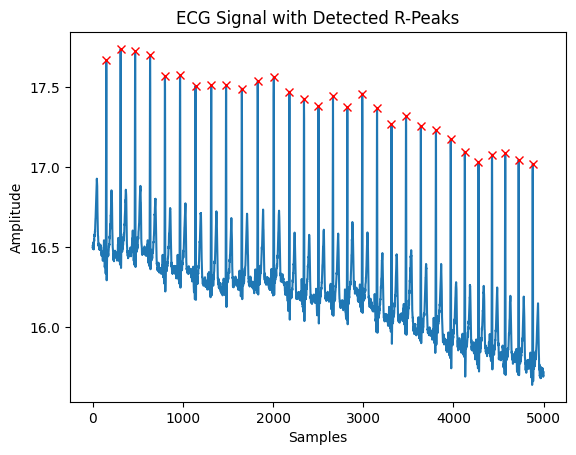

In [ ]:
import matplotlib.pyplot as plt

example_signal = np.array(df.loc[0, 'raw data'])
r_peaks = detect_r_peaks(example_signal, sampling_rate=1000)

plt.plot(example_signal)
plt.plot(r_peaks, example_signal[r_peaks], 'rx')  # Mark peaks
plt.title("ECG Signal with Detected R-Peaks")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

#R-R Interval handaling

In [ ]:
def compute_rr_intervals(r_peaks, sampling_rate=1000):
    if r_peaks is None or len(r_peaks) < 2:
        return None  # Need at least 2 peaks
    rr_intervals = np.diff(r_peaks) / sampling_rate  # in seconds
    return rr_intervals.tolist()

df['RR_Intervals'] = df['R_Peaks'].apply(lambda peaks: compute_rr_intervals(peaks, sampling_rate=1000))

# ✅ Check result
print(df[['Participant Id', 'Session ID', 'Video ID', 'RR_Intervals']].head())

   Participant Id  Session ID  Video ID  \
0               1           1         1   
1               1           1         2   
2               1           1         3   
3               1           1         4   
4               1           1         5   

                                        RR_Intervals  
0  [0.16, 0.16, 0.166, 0.165, 0.167, 0.172, 0.174...  
1  [0.16, 0.16, 0.166, 0.165, 0.167, 0.172, 0.174...  
2  [0.162, 0.165, 0.173, 0.175, 0.171, 0.183, 0.1...  
3  [0.192, 0.185, 0.192, 0.193, 0.193, 0.187, 0.1...  
4  [0.189, 0.19, 0.183, 0.173, 0.174, 0.172, 0.16...  


In [ ]:
import numpy as np
from scipy.stats import zscore

def clean_rr_intervals(rr_intervals_ms):
    """Replace outlier RR intervals (e.g., >2 std devs) with median to mitigate artifacts."""
    if rr_intervals_ms is None or len(rr_intervals_ms) == 0:
        return None  # handle missing or empty lists
    rr = np.array(rr_intervals_ms)
    outliers = np.abs(zscore(rr)) > 2
    rr[outliers] = np.median(rr)
    return rr.tolist()

In [ ]:
df['RR_Intervals_ms'] = df['RR_Intervals'].apply(
    lambda rr: [x * 1000 for x in rr] if rr is not None else None
)

df['Cleaned_RR_Intervals_ms'] = df['RR_Intervals_ms'].apply(
    clean_rr_intervals
)

print(df[['Participant Id', 'Session ID', 'Video ID', 'Cleaned_RR_Intervals_ms']].head())


   Participant Id  Session ID  Video ID  \
0               1           1         1   
1               1           1         2   
2               1           1         3   
3               1           1         4   
4               1           1         5   

                             Cleaned_RR_Intervals_ms  
0  [160.0, 160.0, 166.0, 165.0, 167.0, 172.0, 174...  
1  [160.0, 160.0, 166.0, 165.0, 167.0, 172.0, 174...  
2  [162.0, 165.0, 173.0, 175.0, 171.0, 183.0, 165...  
3  [192.0, 185.0, 192.0, 193.0, 193.0, 187.0, 179...  
4  [170.0, 170.0, 183.0, 173.0, 174.0, 172.0, 167...  


# HRV Features

##Time domain features

In [ ]:
def compute_time_domain_features(rr_ms):
    """
    Compute time-domain HRV features from a sequence of RR intervals in milliseconds.
    Returns a dictionary of feature names and values.
    """
    rr = np.asarray(rr_ms)
    features = {}
    if len(rr) < 1:
        return features  # Not enough data
    # Basic statistics
    features['Mean RR (ms)'] = np.mean(rr)
    features['SDNN (ms)'] = np.std(rr, ddof=0)  # population std
    features['Min RR (ms)'] = np.min(rr)
    features['Max RR (ms)'] = np.max(rr)
    # Heart rate metrics (bpm)
    # Convert each RR from ms to bpm: HR = 60000 / RR_ms
    hr_series = 60000.0 / rr
    features['Mean HR (bpm)'] = np.mean(hr_series)
    features['STD HR (bpm)'] = np.std(hr_series, ddof=0)
    features['Min HR (bpm)'] = np.min(hr_series)
    features['Max HR (bpm)'] = np.max(hr_series)
    # RMSSD
    diffs = np.diff(rr)
    features['RMSSD (ms)'] = np.sqrt(np.mean(diffs**2))
    # NN50 and pNN50
    nn50 = np.sum(np.abs(diffs) > 50)
    features['NN50 count'] = nn50
    features['pNN50 (%)'] = 100 * nn50 / len(diffs) if len(diffs) > 0 else 0
    return features

##Frequency domain deatures

In [ ]:
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
from scipy.signal import welch

def compute_frequency_domain_features(rr_ms, interpolation_fs=4.0):
    """
    Compute frequency-domain features (LF, HF power and LF/HF ratio) from RR intervals.
    rr_ms: array of RR intervals in ms.
    interpolation_fs: frequency (Hz) to interpolate RR intervals (default 4 Hz).
    Returns a dictionary of frequency-domain features.
    """
    features = {}
    if len(rr_ms) < 2:
        return features  # Need at least two intervals to compute PSD

    # Prepare time axis for RR intervals (in seconds)
    rr = np.array(rr_ms, dtype=float)
    t = np.cumsum(rr) / 1000.0  # cumulative time in seconds for each beat

    # Interpolate RR interval time series at regular intervals
    interp_fn = interp1d(t, rr, kind='cubic', fill_value="extrapolate")
    total_time = t[-1]
    dt = 1.0 / interpolation_fs
    t_regular = np.arange(0, total_time, dt)
    rr_interpolated = interp_fn(t_regular)

    # Detrend the interpolated series (optional: remove mean)
    rr_interpolated -= np.mean(rr_interpolated)

    # Compute Welch's PSD
    freqs, psd = welch(rr_interpolated, fs=interpolation_fs, nperseg=256)

    # Define band ranges
    bands = {
        "VLF": (0.0, 0.04),
        "LF": (0.04, 0.15),
        "HF": (0.15, 0.40)
    }

    # Integrate power in each band
    band_powers = {}
    for band, (f_low, f_high) in bands.items():
        band_mask = (freqs >= f_low) & (freqs < f_high)
        band_powers[band] = trapezoid(psd[band_mask], freqs[band_mask]) if np.any(band_mask) else 0

    # Compute total power (in defined range up to 0.4 Hz)
    total_power = sum(band_powers.values())
    features["LF power (ms^2)"] = band_powers["LF"]
    features["HF power (ms^2)"] = band_powers["HF"]
    features["LF/HF ratio"] = (band_powers["LF"] / band_powers["HF"]) if band_powers["HF"] > 0 else np.nan
    features["Total Power (ms^2)"] = total_power
    return features

##Non-linear features

In [ ]:
def compute_nonlinear_features(rr_ms):
    """
    Compute non-linear HRV features: Poincaré (SD1, SD2), DFA (alpha1, alpha2), and Sample Entropy.
    Returns a dictionary of features.
    """
    features = {}
    rr = np.asarray(rr_ms, dtype=float)
    if len(rr) < 4:
        return features  # not enough data for nonlinear measures

    # Poincaré plot metrics (SD1, SD2)
    rr_n = rr[:-1]
    rr_n1 = rr[1:]
    diff_rr = rr_n1 - rr_n
    # SD1: std dev of successive differences (perpendicular to identity)
    features['SD1 (ms)'] = np.sqrt(np.var(diff_rr) / 2.0)
    # SD2: std dev along identity
    features['SD2 (ms)'] = np.sqrt(2.0 * np.var(rr) - 0.5 * np.var(diff_rr))
    features['SD1/SD2'] = features['SD1 (ms)'] / features['SD2 (ms)'] if features['SD2 (ms)'] != 0 else np.nan

    # Detrended Fluctuation Analysis (DFA) via NeuroKit or other library
    if nk is not None:
        try:
            dfa = nk.fractal_dfa(rr, show=False)
            # NeuroKit's fractal_dfa returns a dict with 'α1' and 'α2'
            features['DFA α1'] = dfa.get('FD_DFA_alpha1') or dfa.get('Fractal_DFA_alpha1')
            features['DFA α2'] = dfa.get('FD_DFA_alpha2') or dfa.get('Fractal_DFA_alpha2')
        except Exception:
            # If NeuroKit2 changed API or fails, skip DFA
            pass

    # Sample Entropy (using NeuroKit2 or a quick implementation)
    if nk is not None:
        try:
            sampen = nk.entropy_sample(rr, dimension=2, tolerance='default')
            features['Sample Entropy'] = sampen
        except Exception:
            pass
    # If NeuroKit2 isn't available, one could implement Sample Entropy or use another library (e.g., antropy).
    return features

##add features to data frame

In [ ]:
# Master extraction function
def extract_all_hrv_features(rr_ms):
    if rr_ms is None or len(rr_ms) < 2:
        return {}
    time_feats = compute_time_domain_features(rr_ms)
    freq_feats = compute_frequency_domain_features(rr_ms)
    nonlinear_feats = compute_nonlinear_features(rr_ms)
    return {**time_feats, **freq_feats, **nonlinear_feats}

# Apply to each row
hrv_feature_dicts = df['Cleaned_RR_Intervals_ms'].apply(extract_all_hrv_features)

# Convert to DataFrame
hrv_features_df = pd.DataFrame(hrv_feature_dicts.tolist())

# Combine with main DataFrame
df = pd.concat([df, hrv_features_df], axis=1)

# ✅ Check the result
print(df.head())


/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 19, using nperseg = 19
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/neurokit2/complexity/fractal_dfa.py:415: UserWarning: All detrended segments have no variance. Retuning NaN.
  warn("All detrended segments have no variance. Retuning NaN.")
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 19, using nperseg = 19
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/neurokit2/complexity/fractal_dfa.py:415: UserWarning: All detrended segments have no variance. Retuning NaN.
  warn("All detrended segments have no variance. Retuning NaN.")
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than

   Participant Id  Session ID  Video ID Name  Age    Male  Valence level  \
0               1           1         1  M_W   21  Female              6   
1               1           1         2  M_W   21  Female              2   
2               1           1         3  M_W   21  Female              7   
3               1           1         4  M_W   21  Female              7   
4               1           1         5  M_W   21  Female              0   

  Arousal level  Dominance level     Happy  ... NN50 count pNN50 (%)  \
0             0                0  Moderate  ...        0.0       0.0   
1             4                2   VeryLow  ...        0.0       0.0   
2             6                6  Moderate  ...        0.0       0.0   
3             3                4  Moderate  ...        0.0       0.0   
4             8                8   VeryLow  ...        0.0       0.0   

  LF power (ms^2) HF power (ms^2) LF/HF ratio Total Power (ms^2)  SD1 (ms)  \
0             0.0             0.

/usr/local/lib/python3.11/dist-packages/neurokit2/complexity/fractal_dfa.py:415: UserWarning: All detrended segments have no variance. Retuning NaN.
  warn("All detrended segments have no variance. Retuning NaN.")
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 19, using nperseg = 19
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/neurokit2/complexity/fractal_dfa.py:415: UserWarning: All detrended segments have no variance. Retuning NaN.
  warn("All detrended segments have no variance. Retuning NaN.")
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 20, using nperseg = 20
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/neurokit2/complexity/fractal_dfa.py:415: UserWarning: All detrended segments

In [ ]:
print(df.columns)

Index(['Participant Id', 'Session ID', 'Video ID', 'Name', 'Age', 'Male',
       'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Sad',
       'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Familiarity Score',
       'Emotion', 'Valence', 'Arousal', 'Four_Label', 'raw data', 'Gender',
       'V_Label', 'A_Label', 'Four_Labels', 'R_Peaks', 'RR_Intervals',
       'RR_Intervals_ms', 'Cleaned_RR_Intervals_ms', 'Mean RR (ms)',
       'SDNN (ms)', 'Min RR (ms)', 'Max RR (ms)', 'Mean HR (bpm)',
       'STD HR (bpm)', 'Min HR (bpm)', 'Max HR (bpm)', 'RMSSD (ms)',
       'NN50 count', 'pNN50 (%)', 'LF power (ms^2)', 'HF power (ms^2)',
       'LF/HF ratio', 'Total Power (ms^2)', 'SD1 (ms)', 'SD2 (ms)', 'SD1/SD2',
       'Sample Entropy'],
      dtype='object')


In [ ]:
print(df.head())

   Participant Id  Session ID  Video ID Name  Age    Male  Valence level  \
0               1           1         1  M_W   21  Female              6   
1               1           1         2  M_W   21  Female              2   
2               1           1         3  M_W   21  Female              7   
3               1           1         4  M_W   21  Female              7   
4               1           1         5  M_W   21  Female              0   

  Arousal level  Dominance level     Happy  ... NN50 count pNN50 (%)  \
0             0                0  Moderate  ...        0.0       0.0   
1             4                2   VeryLow  ...        0.0       0.0   
2             6                6  Moderate  ...        0.0       0.0   
3             3                4  Moderate  ...        0.0       0.0   
4             8                8   VeryLow  ...        0.0       0.0   

  LF power (ms^2) HF power (ms^2) LF/HF ratio Total Power (ms^2)  SD1 (ms)  \
0             0.0             0.

In [ ]:
df.to_csv('hrv_features_to_emotion.csv', index=False)

from google.colab import files
files.download('hrv_features_to_emotion.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>